# EDA with Synthetic Data

In [1]:
# Import dependencies 
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [76]:
# Load data
cgm_df = pd.read_csv('/20230605_synthetic_T1DB_dataset.csv')

In [77]:
cgm_df.head()

,Time,BG,CGM,CHO,insulin,LBGI,HBGI,Risk,subject
0,2023-06-04 00:00:00,138.56,155.333949,0.0,0.021125,0.0,1.510902,1.510902,adult#001
1,2023-06-04 00:03:00,138.56,151.122022,0.0,0.021125,0.0,1.510902,1.510902,adult#001
2,2023-06-04 00:06:00,138.56,148.779373,0.0,0.021125,0.0,1.510902,1.510902,adult#001
3,2023-06-04 00:09:00,138.56,147.012710,0.0,0.021125,0.0,1.510902,1.510902,adult#001
4,2023-06-04 00:12:00,138.56,145.648950,0.0,0.021125,0.0,1.510902,1.510902,adult#001


## Key Observations


*   There are 10 unique subjects each with CGM data recorded over 11 days. 
*   Each subject has between 35-43 meals recorded.
*   The minimum amount of time between meals across subjects is 42 minutes.
*   The average amount of time between meals across subjects is ~6 hours.





In [78]:
# There are 10 unique subjects
cgm_df['subject'].unique()

array(['adult#001', 'adult#002', 'adult#003', 'adult#004', 'adult#005',
       'adult#006', 'adult#007', 'adult#008', 'adult#009', 'adult#010'],
      dtype=object)

In [79]:
# Convert time to datetime object
cgm_df['Time'] = pd.to_datetime(cgm_df['Time'])

# Create hour and minute columns 
def hr_func(ts):
    return ts.hour

def minute_func(ts):
    return ts.minute

cgm_df['hour'] = cgm_df['Time'].apply(hr_func)
cgm_df['minute'] = cgm_df['Time'].apply(minute_func)
cgm_df['day'] = cgm_df['Time'].dt.day
cgm_df['month'] = cgm_df['Time'].dt.month

from pandas.core.internals.concat import NaT
# Indicate meal start time 
cgm_df['meal_start_time'] = np.where(cgm_df['CHO']>0, cgm_df['Time'], NaT)
cgm_df['meal_start_time'] = pd.to_datetime(cgm_df['meal_start_time'])

In [82]:
# View number of unique meal starts per subject
cgm_df.groupby('subject')['meal_start_time'].nunique()

subject
adult#001    39
adult#002    39
adult#003    39
adult#004    37
adult#005    36
adult#006    36
adult#007    35
adult#008    40
adult#009    36
adult#010    43
Name: meal_start_time, dtype: int64

In [83]:
# Observe difference in time between meals
# Subset data for only meal start times
meals = cgm_df[cgm_df['meal_start_time'].notnull()]

# Calculate difference between meal start times in hours and minutes 
meals['previous_meal_start_time'] = meals.groupby('subject')['meal_start_time'].shift()
meals['hours_bw_meals'] = (((meals['meal_start_time'] - meals['previous_meal_start_time']).dt.total_seconds()) / 60) / 60
meals['minutes_bw_meals'] = ((meals['meal_start_time'] - meals['previous_meal_start_time']).dt.total_seconds()) / 60

In [88]:
meals.groupby('subject')['minutes_bw_meals'].min()

subject
adult#001     42.0
adult#002     81.0
adult#003     66.0
adult#004     84.0
adult#005    138.0
adult#006     87.0
adult#007     96.0
adult#008     51.0
adult#009     90.0
adult#010     69.0
Name: minutes_bw_meals, dtype: float64

In [90]:
meals.groupby('subject')['hours_bw_meals'].mean()

subject
adult#001    6.003947
adult#002    5.814474
adult#003    5.827632
adult#004    6.436111
adult#005    6.477143
adult#006    6.497143
adult#007    6.576471
adult#008    5.794872
adult#009    6.535714
adult#010    5.544048
Name: hours_bw_meals, dtype: float64

In [100]:
meals.groupby('day')['hours_bw_meals'].mean().mean()

6.092711736119631

In [91]:
cgm_df.groupby('subject')['day'].nunique()

subject
adult#001    11
adult#002    11
adult#003    11
adult#004    11
adult#005    11
adult#006    11
adult#007    11
adult#008    11
adult#009    11
adult#010    11
Name: day, dtype: int64

## View Glucose Levels Against Meal Starts
There are higher spikes in glucose levels following meals with more carbohydrates.



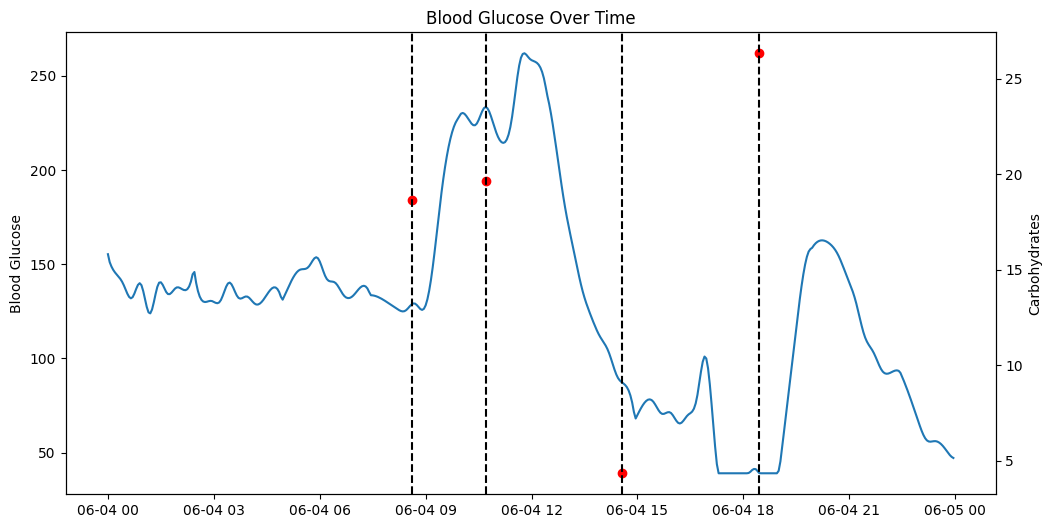

In [129]:
# Subject 1, Day 1
subj1_day1_cgm = cgm_df[(cgm_df['subject']=='adult#001') & (cgm_df['day']==4)]
subj1_day1_cgm.loc[subj1_day1_cgm['CHO'] == 0,'CHO'] = np.nan
subj1_day1_meals = meals[(meals['subject']=='adult#001') & (meals['day']==4)]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(subj1_day1_cgm['Time'], subj1_day1_cgm['CGM'])
ax2.scatter(subj1_day1_cgm['Time'], subj1_day1_cgm['CHO'], c='red')
ax1.set_ylabel('Blood Glucose')
ax2.set_ylabel('Carbohydrates')
plt.title('Blood Glucose Over Time')
xcoords = subj1_day1_meals['Time'].tolist()
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')


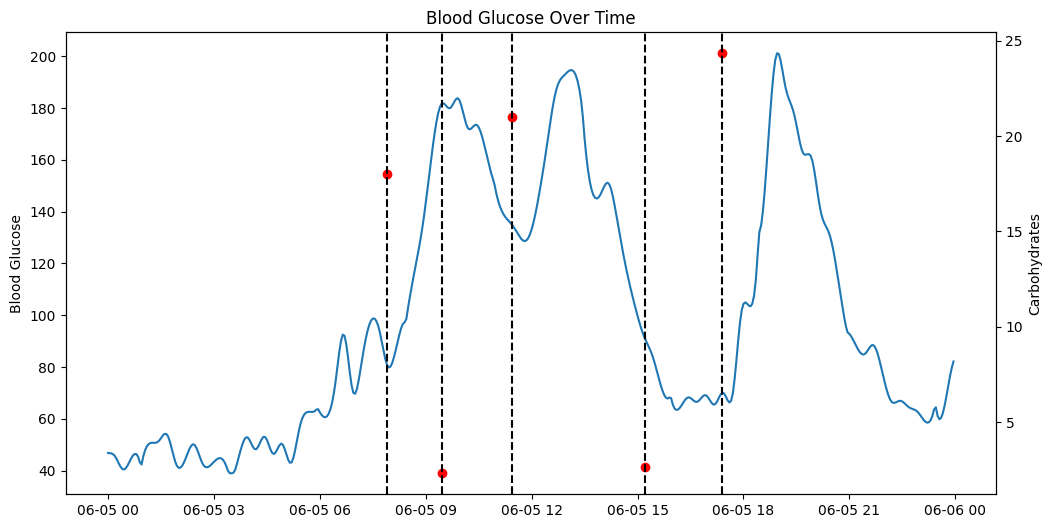

In [131]:
# Subject 1, Day 2
subj1_day2_cgm = cgm_df[(cgm_df['subject']=='adult#001') & (cgm_df['day']==5)]
subj1_day2_cgm.loc[subj1_day2_cgm['CHO'] == 0,'CHO'] = np.nan
subj1_day2_meals = meals[(meals['subject']=='adult#001') & (meals['day']==5)]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(subj1_day2_cgm['Time'], subj1_day2_cgm['CGM'])
ax2.scatter(subj1_day2_cgm['Time'], subj1_day2_cgm['CHO'], c='red')
ax1.set_ylabel('Blood Glucose')
ax2.set_ylabel('Carbohydrates')
plt.title('Blood Glucose Over Time')
xcoords = subj1_day2_meals['Time'].tolist()
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

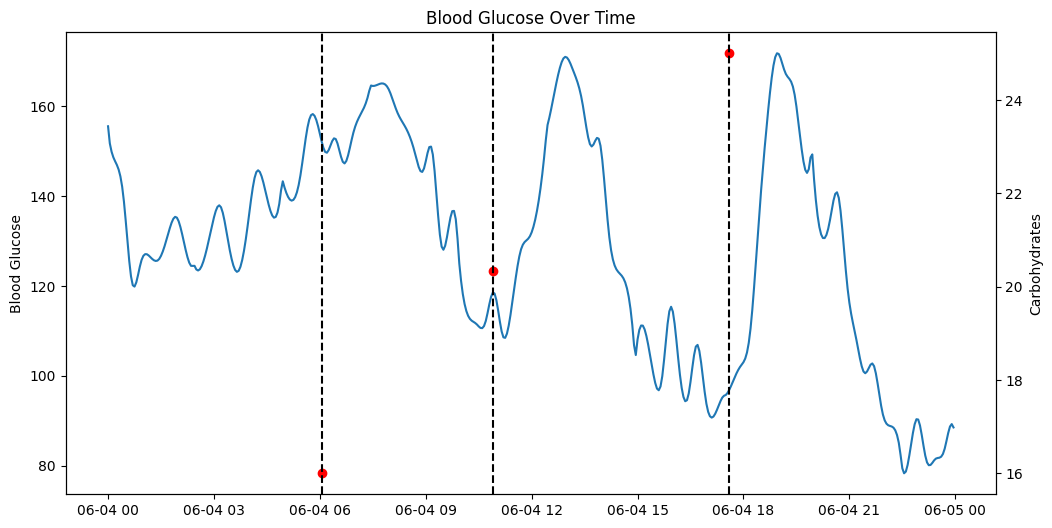

In [132]:
# Subject 2, Day 1
subj2_day1_cgm = cgm_df[(cgm_df['subject']=='adult#002') & (cgm_df['day']==4)]
subj2_day1_cgm.loc[subj2_day1_cgm['CHO'] == 0,'CHO'] = np.nan
subj2_day1_meals = meals[(meals['subject']=='adult#002') & (meals['day']==4)]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(subj2_day1_cgm['Time'], subj2_day1_cgm['CGM'])
ax2.scatter(subj2_day1_cgm['Time'], subj2_day1_cgm['CHO'], c='red')
ax1.set_ylabel('Blood Glucose')
ax2.set_ylabel('Carbohydrates')
plt.title('Blood Glucose Over Time')
xcoords = subj2_day1_meals['Time'].tolist()
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

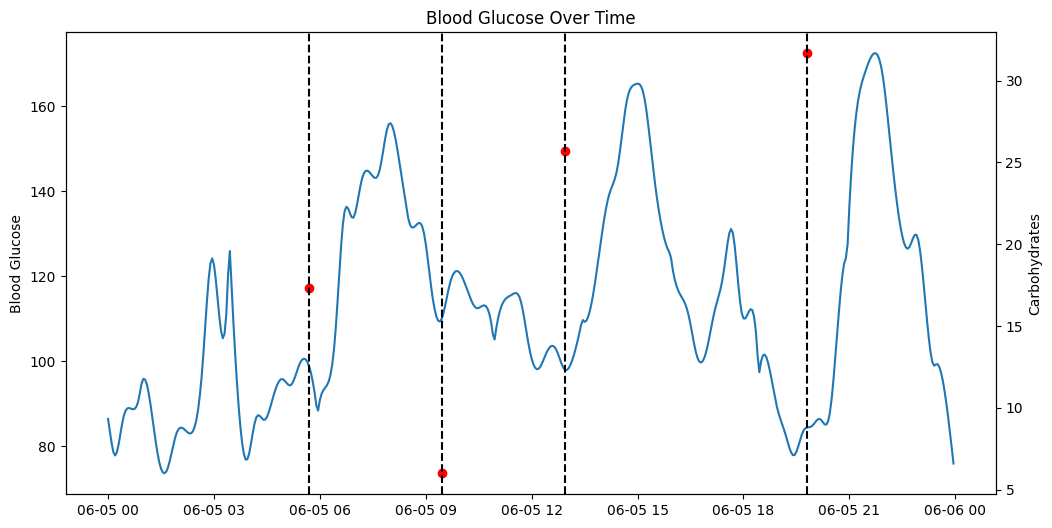

In [133]:
# Subject 2, Day 2
subj2_day2_cgm = cgm_df[(cgm_df['subject']=='adult#002') & (cgm_df['day']==5)]
subj2_day2_cgm.loc[subj2_day2_cgm['CHO'] == 0,'CHO'] = np.nan
subj2_day2_meals = meals[(meals['subject']=='adult#002') & (meals['day']==5)]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(subj2_day2_cgm['Time'], subj2_day2_cgm['CGM'])
ax2.scatter(subj2_day2_cgm['Time'], subj2_day2_cgm['CHO'], c='red')
ax1.set_ylabel('Blood Glucose')
ax2.set_ylabel('Carbohydrates')
plt.title('Blood Glucose Over Time')
xcoords = subj2_day2_meals['Time'].tolist()
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')